## Preprocessing

In [2]:
import pandas as pd
import numpy as np
import glob
from pyntcloud import PyntCloud

In [40]:
def load_ply(file_name):
    cloud = PyntCloud.from_file(file_name)
    return cloud.points.values

In [41]:
def load_obj(file_name):
    vertices = []
    with open(file_name) as f:
        for line in f:
            if line[:2] == 'v ':
                index1 = line.find(' ') + 1
                index2 = line.find(' ', index1 + 1)
                index3 = line.find(' ', index2 + 1)

                vertex = (float(line[index1:index2]), float(line[index2:index3]), float(line[index3:-1]))
                vertex = [round(vertex[0], 2), round(vertex[1], 2), round(vertex[2], 2)]
                vertices.append(np.array(vertex))
                
    return np.array(vertices)

In [42]:
def load_off(file_name):
    vertices = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            vals = line.split(' ')
            if i > 2 and len(vals) == 3:
                vertex = [float(vals[0]), float(vals[1]), float(vals[2])]
                vertices.append(np.array(vertex))

    return np.random.permutation(np.array(vertices))[:2048]

In [51]:
point_clouds = []
for i, file_name in enumerate(glob.glob('./data/04379243/*.ply')):
    
    points = load_ply(file_name)
    point_clouds.append(points)
    if i == 5:
        break
        
point_clouds = np.array(point_clouds, dtype='float64')

point_clouds.shape

(6, 2048, 3)

## Auto encoder

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [47]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv1d(2048, 256, 1)
        self.conv2 = nn.Conv1d(256, 128, 1)
        self.conv3 = nn.Conv1d(128, 64, 1)
        self.conv4 = nn.Conv1d(64, 32, 1)
        self.maxPool1d = nn.MaxPool1d(3)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxPool1d(x)
        return x

encoder = Encoder()
print(encoder)

Encoder(
  (conv1): Conv1d(2048, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (maxPool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
)


In [48]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2048*3)

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = x.view(-1, 2048, 3)
        
        return x
    
decoder = Decoder()
print(decoder)

Decoder(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6144, bias=True)
)


In [49]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Training

In [52]:
from lib.chamfer import ChamferLoss
model = AutoEncoder() ##.coda()

criterion = ChamferLoss()

num_epochs = 100
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

input = torch.from_numpy(point_clouds).float()

for epoch in range(num_epochs):

    output = model(input)
    loss = criterion(output, input)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [5/100], loss:169.6595
epoch [10/100], loss:85.2608
epoch [15/100], loss:66.2301
epoch [20/100], loss:56.7448
epoch [25/100], loss:49.0438
epoch [30/100], loss:44.9804
epoch [35/100], loss:40.6975
epoch [40/100], loss:36.2570
epoch [45/100], loss:32.2374
epoch [50/100], loss:28.5772
epoch [55/100], loss:25.3610
epoch [60/100], loss:22.0360
epoch [65/100], loss:18.0814
epoch [70/100], loss:14.6090
epoch [75/100], loss:12.1850
epoch [80/100], loss:10.6872
epoch [85/100], loss:9.5305
epoch [90/100], loss:8.6762
epoch [95/100], loss:7.9735
epoch [100/100], loss:7.3970


## Validation

#### training data

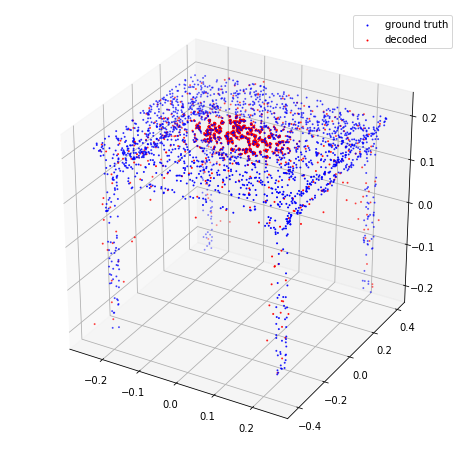

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

output = model(input)
output.detach().numpy()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

index = 3

data = input[index].detach().numpy().T
ax.scatter(data[0], data[1], data[2], zdir='z', s=1, c='b', label='ground truth')

data = output[index].detach().numpy().T
ax.scatter(data[0], data[1], data[2], zdir='z', s=1, c='r', label='decoded')

ax.legend()
plt.show()

#### training (generator)

In [60]:
class Generator(nn.Module):
    
    def __init__(self, auto_encoder):
        super(Generator, self).__init__()

        self.encoder = auto_encoder.encoder
        self.decoder = auto_encoder.decoder

    def forward(self, x):

        x = self.encoder(x)
        x[:,0,0] += 0.9
        x = self.decoder(x)
        
        return x

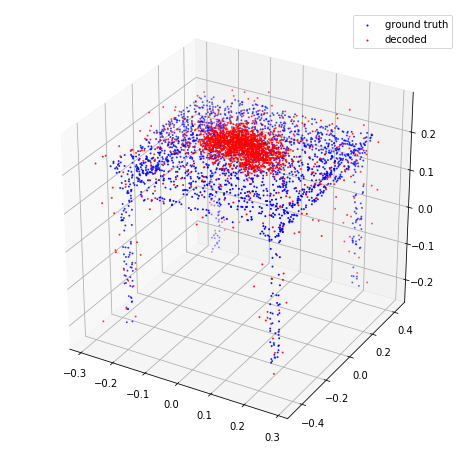

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

generator = Generator(model)
generator_output = generator(input)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

index = 3

data = input[index].detach().numpy().T
ax.scatter(data[0], data[1], data[2], zdir='z', s=1, c='b', label='ground truth')

data = generator_output[index].detach().numpy().T
ax.scatter(data[0], data[1], data[2], zdir='z', s=1, c='r', label='decoded')

ax.legend()
plt.show()

#### test data

In [75]:
test_input = []
for i, file_name in enumerate(glob.glob('./test/*.off')):
    
    points = load_off(file_name)
    if len(points) == 2048 and len(test_input) < 3:
        test_input.append(points)

test_input = np.array(test_input, dtype='float64')

test_input = torch.from_numpy(test_input).float()

print(test_input.shape)

torch.Size([3, 2048, 3])


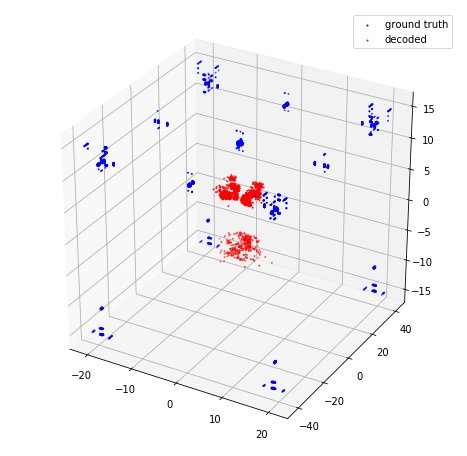

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

test_output = model(test_input)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

index = 0

data = test_input[index].detach().numpy().T
ax.scatter(data[0], data[1], data[2], zdir='z', s=1, c='b', label='ground truth')

data = test_output[index].detach().numpy().T
ax.scatter(data[0], data[1], data[2], zdir='z', s=1, c='r', label='decoded')

ax.legend()
plt.show()

## TODOs

* enable GPU (using Window PC or Google Colaboratory)
* convert mesh to point clouds for preprocessing
* Create a mesh by marching cubes
* Manimulate latent vector or try something else to generate more nice images

## Misc

In [ ]:
input = torch.randn(10, 2048, 3)
print(input.shape)
m = nn.Conv1d(2048, 256, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(256, 128, 1)
output = m(output)
m = nn.Conv1d(128, 64, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(64, 32, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(3)
output = m(output)
print(output.shape)